In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import matplotlib.animation as animation
import csv
# matplotlib.style.use('seaborn')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from wordcloud import WordCloud

from mpl_toolkits.mplot3d import Axes3D

In [2]:
author_data=pd.read_csv("author_data.csv")
author_data.index=author_data.id
author_data=author_data[["gender","age","topic","sign","grupo_edad","Freq"]]
author_data.sample(20)

gender  age                 topic         sign grupo_edad  Freq
id                                                                      
4278520  female   26    Telecommunications        Virgo          B     2
2517845    male   15  Communications-Media        Libra          A    52
3818445  female   15               Student       Taurus          A     9
3816821  female   23               Student          Leo          B     6
4225018    male   14               Student       Taurus          A     6
3536952  female   26                indUnk       Gemini          B     4
4283565  female   17                indUnk       Pisces          A     6
4253344  female   23             Education          Leo          B     7
3870614    male   16             Chemicals      Scorpio          A    10
4092295  female   17                indUnk     Aquarius          A     7
3843378    male   27                  Arts       Gemini          B     5
3972305  female   16               Student        Virgo          A     5
3766760    male   15               Student  Sagittarius          A    16
4135893    male   17               Biotech        Libra          A    10
3860294    male   14                indUnk    Capricorn          A    16
887044   female   23                indUnk       Pisces          B   366
3572043    male   17               Student          Leo          A    12
4171607    male   41                indUnk    Capricorn          C     1
3464884  female   17                indUnk      Scorpio          A    11
4295043  female   17                indUnk       Gemini          A     2

In [3]:
words=pd.read_csv("frq_outh_complete_colnames.csv",header=None,index_col=None)

In [4]:
tfidf_data=pd.read_csv("frq_outh_complete_1.csv",header=None,index_col=None)#_2# This dataframe is already normalized to max val
tfidf_data.index=author_data.index
tfidf_data.columns=list(words[0])
tfidf_data=tfidf_data.apply(pd.to_numeric,downcast='unsigned')
print(tfidf_data.shape)
tfidf_data.sample(20)

(18981, 500)


though  school  always  ever  better  myself  let  year  another  \
id                                                                          
3982634       2       7       0     1       0       1    1     0        0   
3539291       0       0       0     0       0       0    0     0        0   
3887270       1       0       2     1       0       0    0     0        0   
4052055      45      53      57    34      47      17   49    35       24   
3416559       0       0       0     1       1       0    1     0        3   
3335758       2       2       0     2       1       0    3     0        4   
3434166       3       1       0     0       0       0    0     0        2   
3694451       0       3       0     1       1       0    2     1        0   
4177027       2       0       0     0       0       0    0     0        0   
3481855       1       2       3     1       3       0    1     2        2   
4135893       1       1      11    13       9       6    8     3       14   
998237        0       0       0     1       0       0    0     0        1   
3372326       9       3      33    33      15      17   23     4        5   
3307516       0       1       6     0       0       0    1     0        0   
4104963       5       0       0     1       4       0    1     0        2   
4070413       1       8       1     0       3       3    2     7        1   
3812182       2       2       4     3       2       1    4     8        7   
4235819       2      13       2     0       2       0    4     1        1   
3132358       0       0       1     0       0       1    0     1        0   
3783033       3       1       4     9       2       5    1     1        3   

         many   ...    president  english  cute  longer  internet  dead  rock  \
id              ...                                                             
3982634     0   ...            0        1     0       0         0     0     0   
3539291     0   ...            0        0     0       0         0     0     0   
3887270     0   ...            0        0     0       0         0     0     0   
4052055    25   ...            1       41     0       1         0     2     1   
3416559     1   ...            0        0     0       0         0     0     0   
3335758     4   ...            0        0     0       0        11     0     0   
3434166     0   ...            0        0     0       0         0     0     0   
3694451     0   ...            0        0     0       0         0     0     0   
4177027     0   ...            0        0     0       0         0     0     0   
3481855     0   ...            0        0     0       0         1     2     0   
4135893     1   ...            0        0     2       1         2     1     2   
998237      2   ...            0        0     0       0         0     0     0   
3372326    22   ...            1        2     1       5         1     7     2   
3307516     0   ...            0        0     1       0         0     0     0   
4104963     5   ...            0        0     0       0         0     0     0   
4070413     2   ...            0        1     0       0         0     0     1   
3812182     3   ...            4        3     0       1         7     1     0   
4235819     1   ...            0        0     0       1         0     0     0   
3132358     1   ...            0        0     0       0         0     0     1   
3783033     3   ...            0        0     0       1         0     0     0   

         special  road  forget  
id                              
3982634        0     0       0  
3539291        0     3       0  
3887270        0     0       1  
4052055        6     2       2  
3416559        0     0       0  
3335758        1     0       0  
3434166        1     0       0  
3694451        0     0       0  
4177027        0     0       0  
3481855        0     1       3  
4135893        1     1       0  
998237         0     0       0  
3372326        5     5       7  
3307516        0     0       0  
410

# Clustering semisupervisado
Se reduce dimensionalmente una muestra, se obtienen los cluster y se proyecta estos puntos mediante KNN

In [5]:
# tfidf_data_sample=tfidf_data.sample(frac=.3)
# tfidf_data_sample.shape

In [6]:
# print(tfidf_data.shape)
# print(tfidf_data_sample.shape)

## Reducción dimensional

### PCA

In [7]:
pca=PCA()
pca.fit(tfidf_data)
pca_coords=pca.transform(tfidf_data)

500

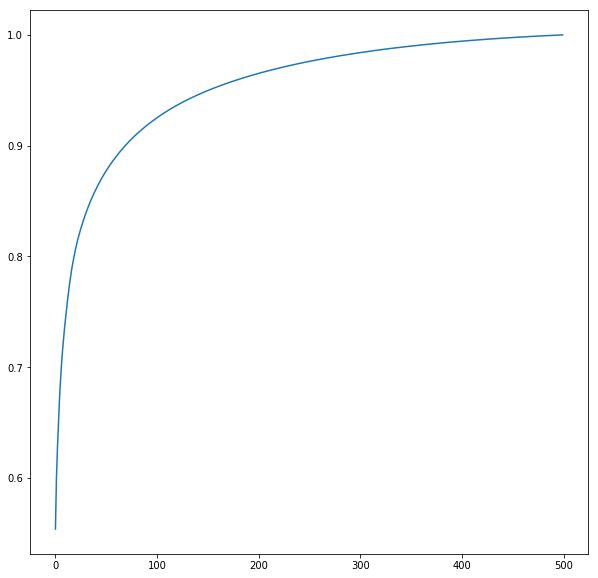

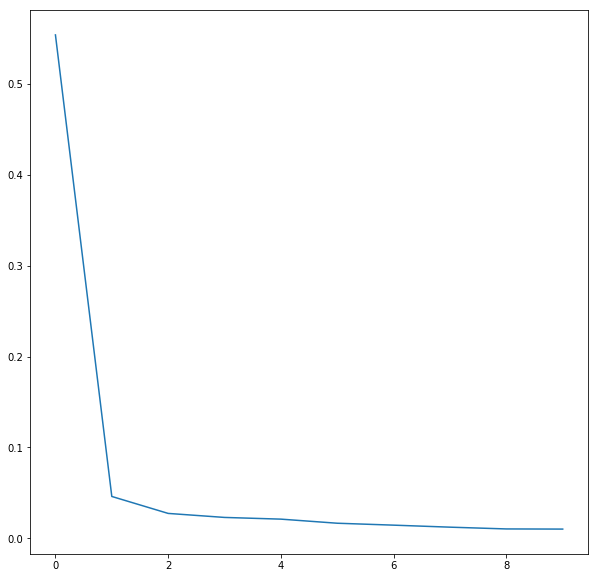

In [8]:
plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_.cumsum())
len(pca.explained_variance_ratio_)

plt.figure(figsize=(10,10))
plt.plot(pca.explained_variance_ratio_[:10])
len(pca.explained_variance_ratio_)

In [9]:
comps_pca_var=pd.DataFrame({"var_comp":pca.explained_variance_ratio_,
              "cumsum":pca.explained_variance_ratio_.cumsum()})

In [10]:
comps_pca_var[comps_pca_var["cumsum"]<=.82]

cumsum  var_comp
0   0.553782  0.553782
1   0.599906  0.046124
2   0.627383  0.027477
3   0.650443  0.023060
4   0.671626  0.021183
5   0.688306  0.016680
6   0.702872  0.014566
7   0.715226  0.012354
8   0.725630  0.010404
9   0.735865  0.010234
10  0.744590  0.008726
11  0.753162  0.008572
12  0.761363  0.008201
13  0.768989  0.007626
14  0.775902  0.006913
15  0.782387  0.006485
16  0.788484  0.006097
17  0.793646  0.005162
18  0.798547  0.004902
19  0.803273  0.004725
20  0.807609  0.004336
21  0.811545  0.003936
22  0.815343  0.003798
23  0.818770  0.003427

In [11]:
auth_ward_PCA=hierarchy.linkage(pca_coords[:,:19], 'ward')#tfidf_data

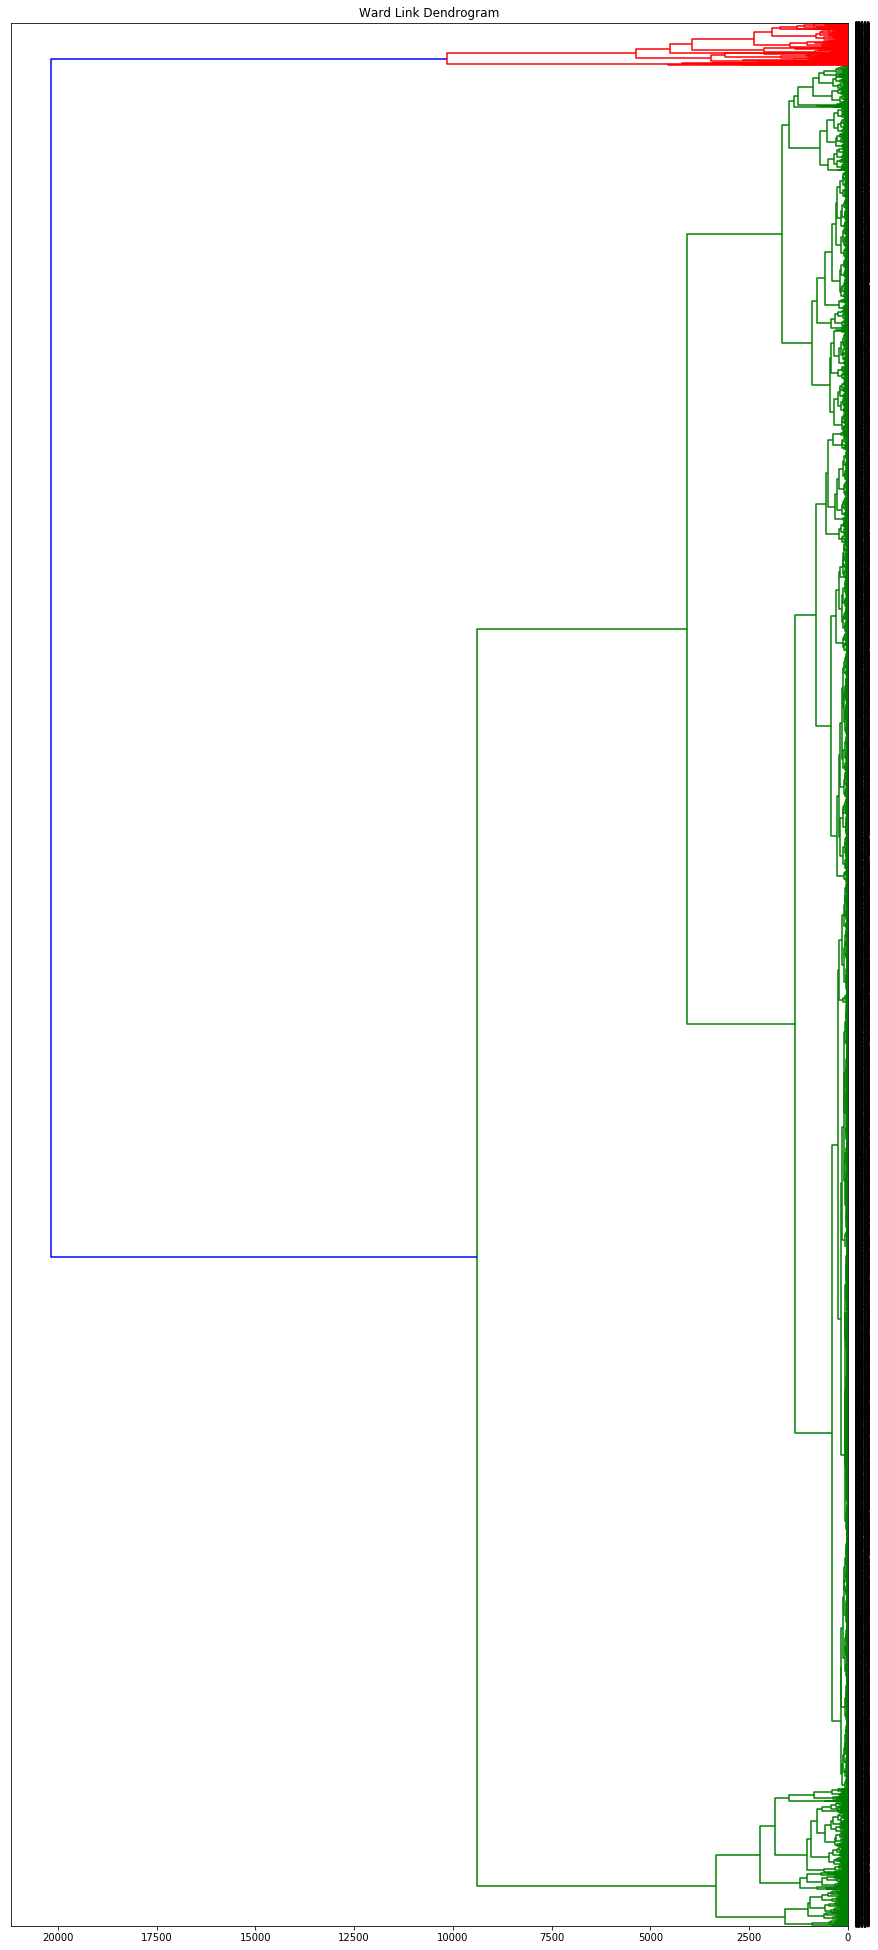

In [12]:
plt.figure(figsize=(15,35))
dn_tf_PCA = hierarchy.dendrogram(auth_ward_PCA,orientation="left")
plt.title('Ward Link Dendrogram')
plt.show()

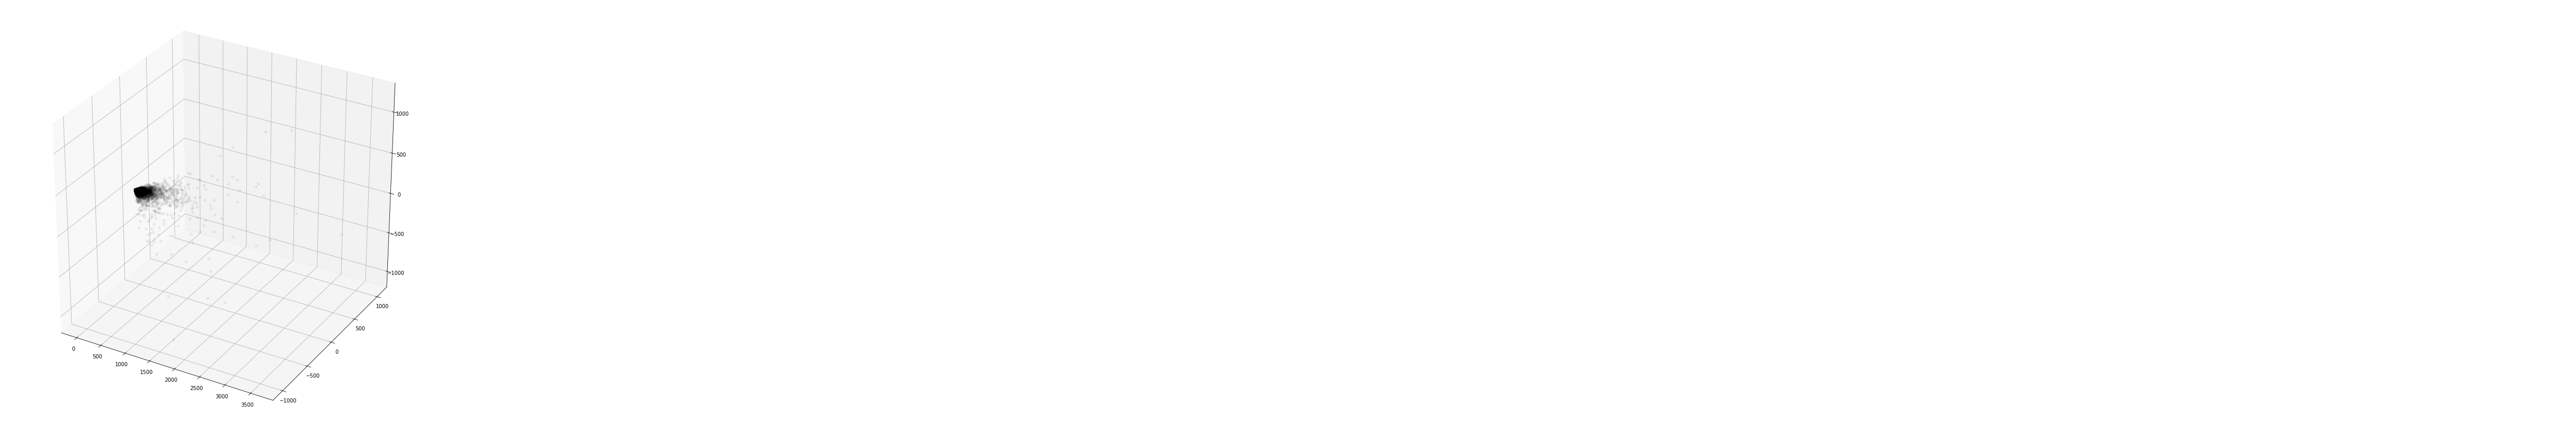

In [13]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=pca_coords[:,0],
           ys=pca_coords[:,1],
           zs=pca_coords[:,2],
           c="black", 
           alpha=.05,
           cmap=plt.cm.Set1)

### Spectral Embedding

In [14]:
# 3d Embedding for visualization
spect_emb_3=manifold.SpectralEmbedding(n_components=19, n_jobs=-1).fit_transform(tfidf_data)#author_data_norm)#

In [15]:
# spect_emb_3=spect_emb_3*1000

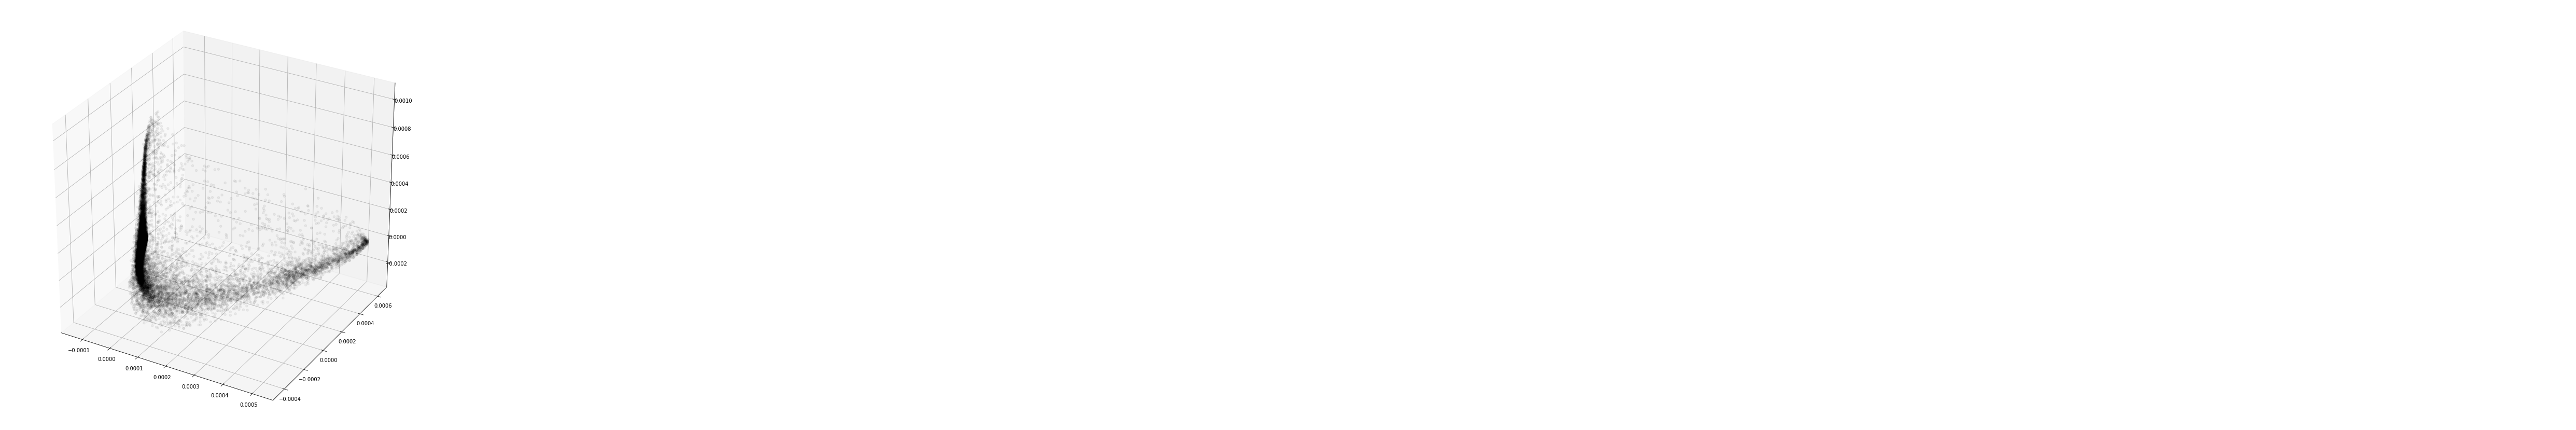

In [16]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=spect_emb_3[:,0],
           ys=spect_emb_3[:,1],
           zs=spect_emb_3[:,2],
           c="black", 
           alpha=.05,
           cmap=plt.cm.Set1)


In [17]:
auth_ward_spect=hierarchy.linkage(spect_emb_3, 'ward')#tfidf_data

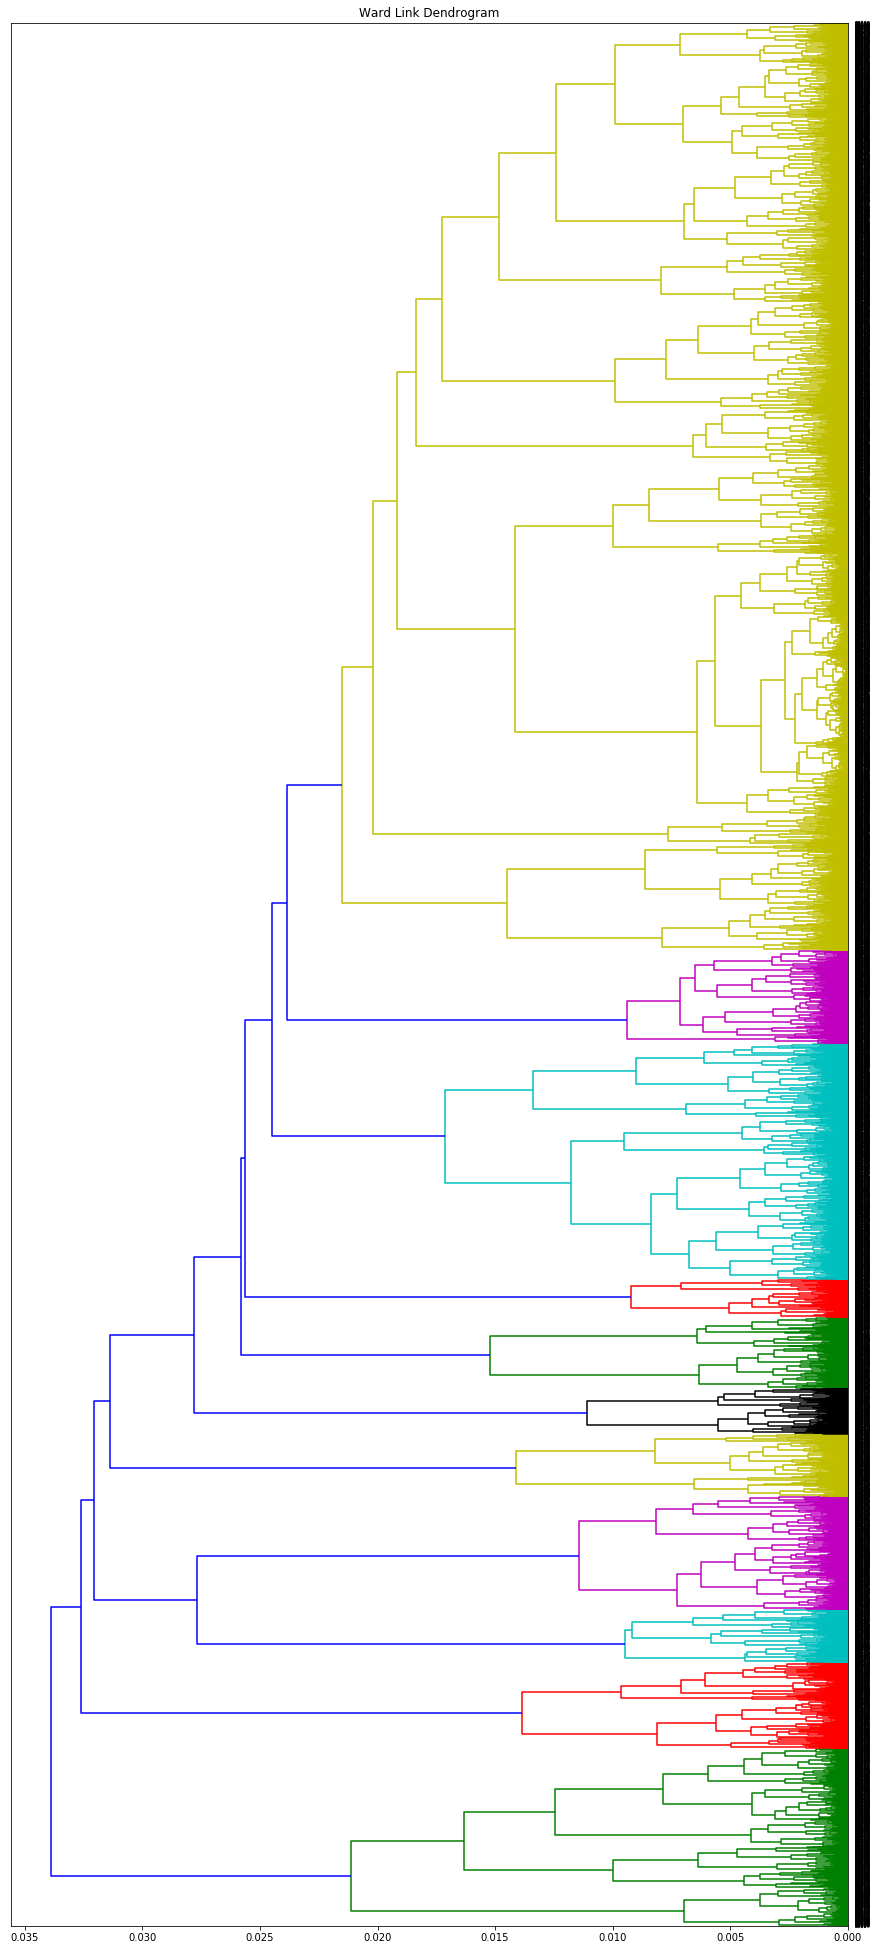

In [18]:
plt.figure(figsize=(15,35))
dn_tf_spect = hierarchy.dendrogram(auth_ward_spect,orientation="left")
plt.title('Ward Link Dendrogram')
plt.show()

#### Conclusiones:

Se define trabajar spectral embedding con 19 dimensiones (tomadas de la varianza explicada del PCA al 80%) y se grafica en las 3 primeras dimensiones del spectral embedding.

# Clustering

In [24]:
connectivity = kneighbors_graph(spect_emb_3, n_neighbors=20, include_self=False, n_jobs=-1)
ward = AgglomerativeClustering(n_clusters=12, connectivity=connectivity,
                               linkage='ward').fit(spect_emb_3)
label = ward.labels_

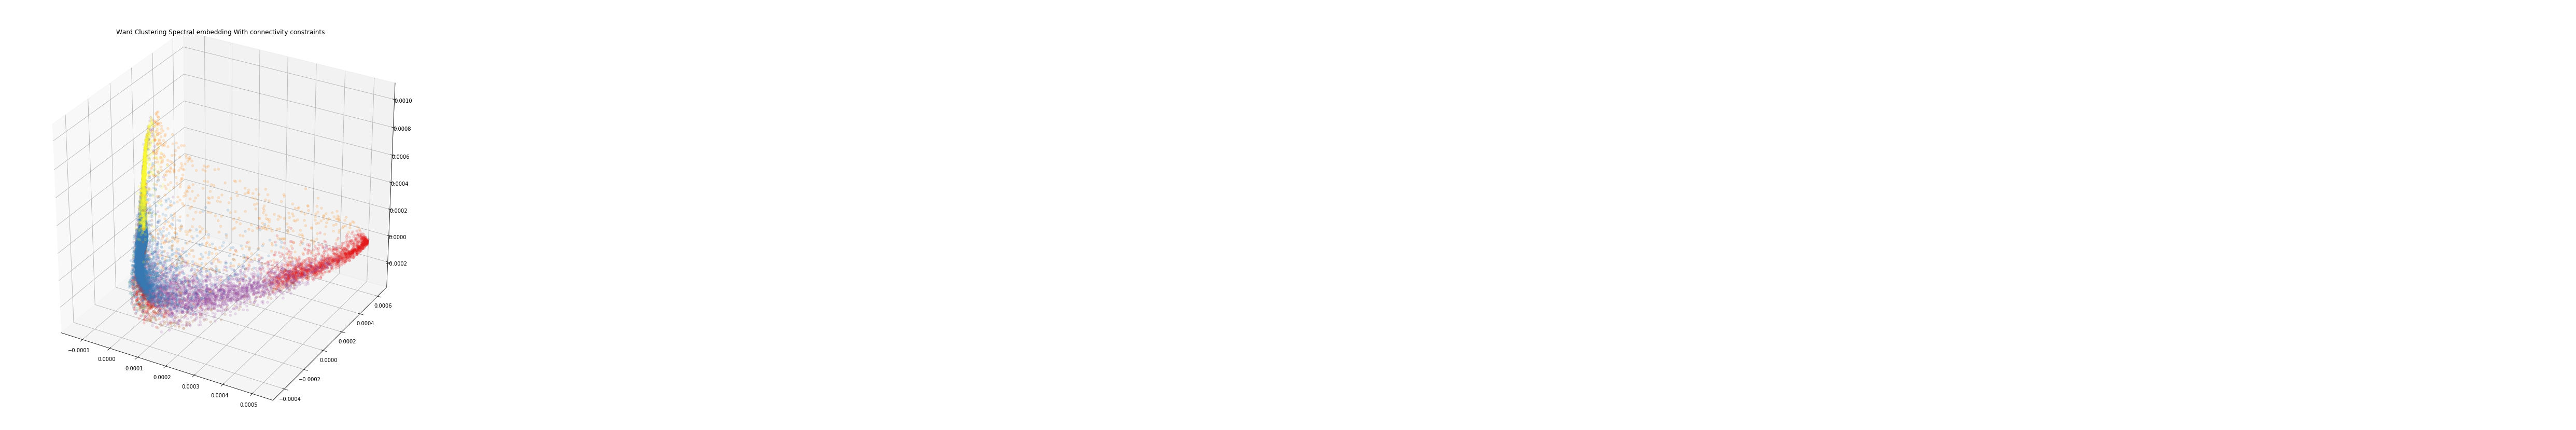

In [25]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for lb in np.unique(label):
    ax.scatter(spect_emb_3[label == lb, 0], 
               spect_emb_3[label == lb, 1], 
               spect_emb_3[label == lb, 2],
               color=plt.cm.Set1(float(lb) / np.max(label + 1)),
               s=20, edgecolor=None, alpha=.15)
plt.title('Ward Clustering Spectral embedding With connectivity constraints')
plt.show()

In [26]:
pd.crosstab(index=label, columns="count")

col_0  count
row_0       
0       1454
1       1267
2       8439
3        890
4       2464
5        487
6        537
7       1067
8        426
9        642
10       882
11       426

Text(0.5, 1.0, '2d spectral coordinates from 3d spectral hierarchical (ward) clustering')

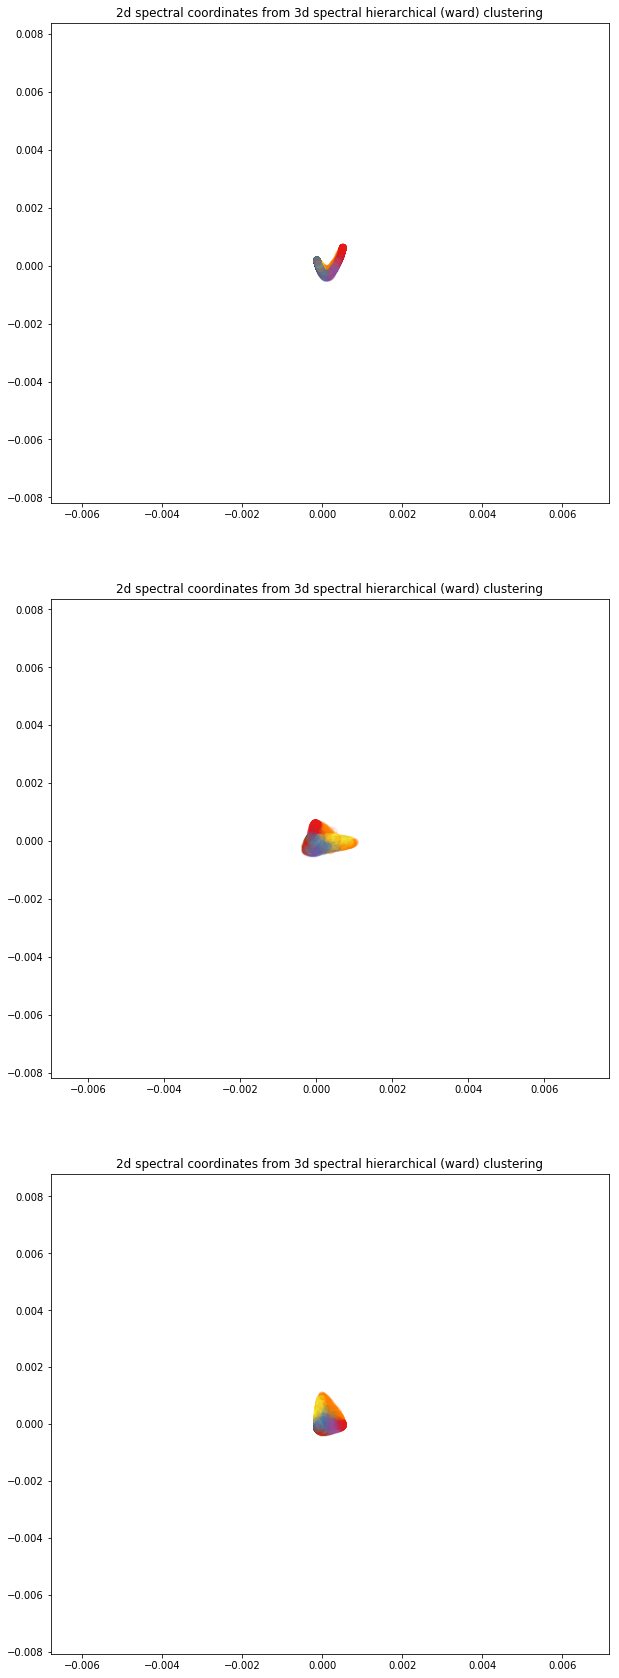

In [27]:
plt.figure(figsize=(10,30))
par_alf=0.1
plt.subplot(311)
plt.scatter(spect_emb_3[:,0],spect_emb_3[:,1], alpha=par_alf,s=45, c=label, cmap=plt.cm.Set1)
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

plt.subplot(312)
plt.scatter(spect_emb_3[:,2],spect_emb_3[:,1], alpha=par_alf,s=45, c=label, cmap=plt.cm.Set1)
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

plt.subplot(313)
plt.scatter(spect_emb_3[:,0],spect_emb_3[:,2], alpha=par_alf,s=45, c=label, cmap=plt.cm.Set1)
plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

## DBScan clustering

In [ ]:
# dist_mat_3d=pairwise_distances(spect_emb_3)

In [ ]:
# dist_vec=dist_mat_3d.flatten()

In [ ]:
# plt.figure(figsize=(16,9))
# # plt.hist(n_grams_tfidf_dist_mat.flatten())
# sns.distplot(dist_vec)
# # sns.kdeplot()

In [ ]:
# freq_dists=pd.crosstab(index=np.round_(dist_vec[dist_vec<.6],3), columns="count")

In [ ]:
# print(freq_dists.iloc[400:500,:])#.iloc[:50,:])
# freq_dists.iloc[400:500,:].plot(kind="bar",figsize=(16,9))##.iloc[200:500,:]
# #0.168

In [ ]:
# max_eps=.475
# min_eps=.45
# eps_par=min_eps+((max_eps-min_eps)/2)
# print(eps_par)

In [ ]:
# db_scan = DBSCAN(eps=eps_par, min_samples=70).fit(spect_emb_3)#spect_emb_tfidf)
# spect_db_labels = db_scan.labels_

In [ ]:
# pd.crosstab(index=spect_db_labels, columns="count")

In [ ]:
# plt.figure(figsize=(10,30))
# par_alf=.01#(spect_db_labels>-.5)*.1#0.1
# plt.title("2d spectral coordinates from 3d spectral hierarchical (ward) clustering")

# plt.subplot(311)
# plt.scatter(spect_emb_3[spect_db_labels==-1,0],spect_emb_3[spect_db_labels==-1,1], alpha=0.05,s=45, c="gray", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==0,0],spect_emb_3[spect_db_labels==0,1], alpha=.1,s=45, c="#4daf4a", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==1,0],spect_emb_3[spect_db_labels==1,1], alpha=.1,s=45, c="#e41a1c", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==2,0],spect_emb_3[spect_db_labels==2,1], alpha=.1,s=45, c="#377eb8", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==3,0],spect_emb_3[spect_db_labels==3,1], alpha=.1,s=45, c="#984ea3", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==4,0],spect_emb_3[spect_db_labels==4,1], alpha=.1,s=45, c="#ff7f00", cmap=plt.cm.Set1)

# plt.subplot(312)
# plt.scatter(spect_emb_3[spect_db_labels==-1,2],spect_emb_3[spect_db_labels==-1,1], alpha=0.05,s=45, c="gray", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==0,2],spect_emb_3[spect_db_labels==0,1], alpha=.1,s=45, c="#4daf4a", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==1,2],spect_emb_3[spect_db_labels==1,1], alpha=.1,s=45, c="#e41a1c", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==2,2],spect_emb_3[spect_db_labels==2,1], alpha=.1,s=45, c="#377eb8", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==3,2],spect_emb_3[spect_db_labels==3,1], alpha=.1,s=45, c="#984ea3", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==4,2],spect_emb_3[spect_db_labels==4,1], alpha=.1,s=45, c="#ff7f00", cmap=plt.cm.Set1)

# plt.subplot(313)
# plt.scatter(spect_emb_3[spect_db_labels==-1,0],spect_emb_3[spect_db_labels==-1,2], alpha=0.05,s=45, c="gray", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==0,0],spect_emb_3[spect_db_labels==0,2], alpha=.1,s=45, c="#4daf4a", cmap=plt.cm.Set1)
# plt.scatter(spect_emb_3[spect_db_labels==1,0],spect_emb_3[spect_db_labels==1,2], alpha=.1,s=45, c="#e41a1c", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==2,0],spect_emb_3[spect_db_labels==2,2], alpha=.1,s=45, c="#377eb8", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==3,0],spect_emb_3[spect_db_labels==3,2], alpha=.1,s=45, c="#984ea3", cmap=plt.cm.Set1)
# # plt.scatter(spect_emb_3[spect_db_labels==4,0],spect_emb_3[spect_db_labels==4,2], alpha=.1,s=45, c="#ff7f00", cmap=plt.cm.Set1)


# Animate - Export 3d clusters

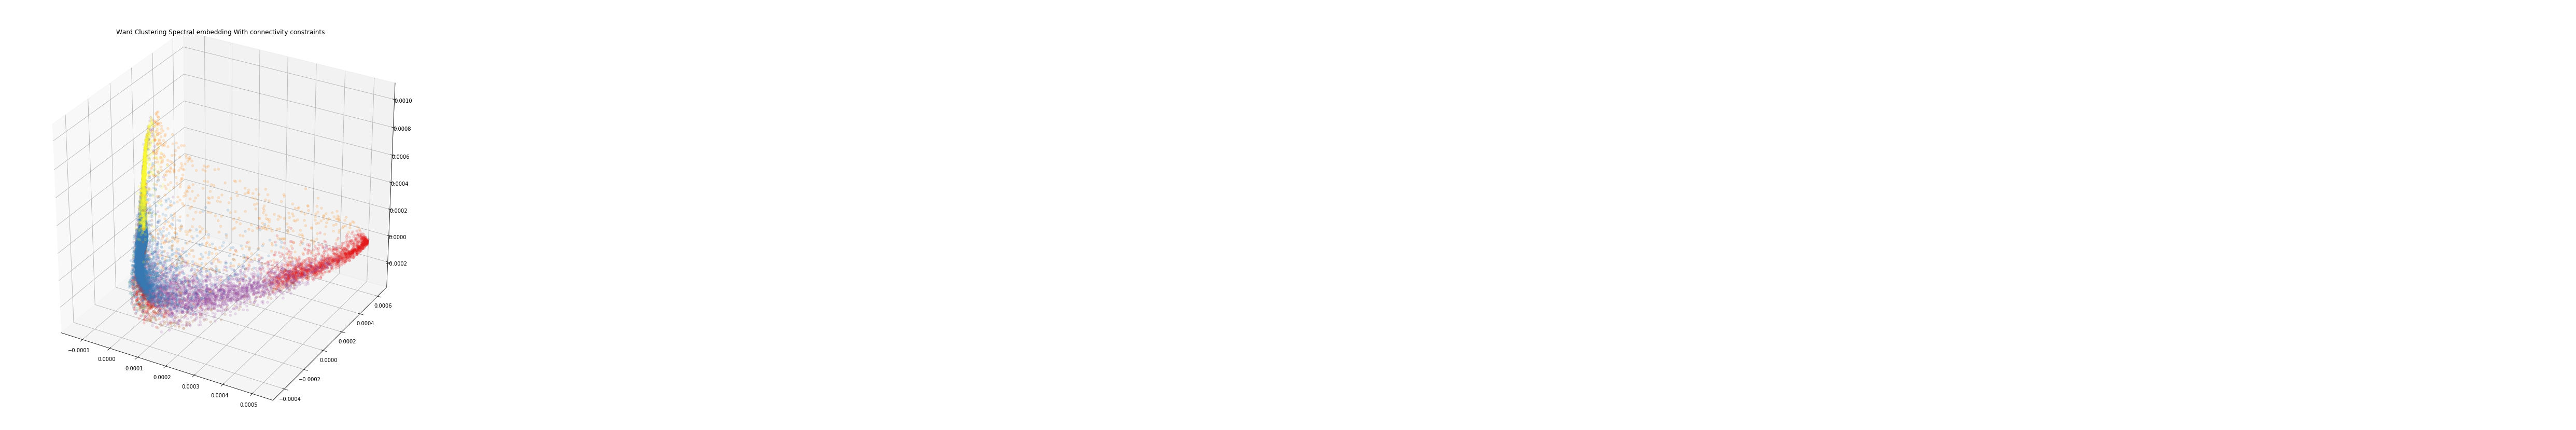

Making animation
Saving Movie File
Saving animated GIF File


In [28]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for lb in np.unique(label):
    ax.scatter(spect_emb_3[label == lb, 0], 
               spect_emb_3[label == lb, 1], 
               spect_emb_3[label == lb, 2],
               color=plt.cm.Set1(float(lb) / np.max(label + 1)),
               s=20, edgecolor=None, alpha=.15)
plt.title('Ward Clustering Spectral embedding With connectivity constraints')
plt.show()
# plt.axis('off') # remove axes for visual appeal

def rotate(angle):
    ax.view_init(azim=angle)

print("Making animation")
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
print("Saving Movie File")
rot_animation.save('cluster_anim_4.mp4', writer=writer)
print("Saving animated GIF File")
rot_animation.save('whljgr_clustering_4.gif', dpi=80, writer='imagemagick')

In [29]:
author_data["cluster"]=label
author_data["embd_x_coord"]=spect_emb_3[:,0]
author_data["embd_y_coord"]=spect_emb_3[:,1]
author_data["embd_z_coord"]=spect_emb_3[:,2]

In [30]:
author_data.head(30)

gender  age                 topic         sign grupo_edad  Freq  \
id                                                                         
2059027    male   15               Student          Leo          A     4   
3581210    male   33     InvestmentBanking     Aquarius          C    70   
3539003  female   14                indUnk        Aries          A    21   
4172416  female   25                indUnk    Capricorn          B     2   
3668238  female   17               Student       Gemini          A    10   
4030905  female   17               Student        Aries          A    25   
4198080  female   23                indUnk     Aquarius          B     1   
3705830    male   25            Non-Profit       Cancer          B    46   
3649763  female   33               Banking     Aquarius          C    13   
3389918  female   37                indUnk     Aquarius          C    19   
4304458  female   25                indUnk  Sagittarius          B     3   
3429420    male   15               Student     Aquarius          A    34   
3389671    male   26                indUnk          Leo          B    35   
649790   female   24                indUnk      Scorpio          B   191   
3022585  female   27             Education     Aquarius          B    85   
3808902  female   45                indUnk  Sagittarius          C    14   
3176655    male   24           Engineering        Libra          B   119   
3667495    male   15               Science        Libra          A    29   
3486574  female   15               Student       Gemini          A     5   
4275555  female   34                indUnk      Scorpio          C     6   
1240631    male   41  Communications-Media        Libra          C    14   
3711014    male   24      BusinessServices       Cancer          B    19   
3168577    male   23                indUnk  Sagittarius          B    49   
1550279    male   17               Student  Sagittarius          A    32   
1916038  female   14                indUnk       Cancer          A     3   
3568056    male   17     Sports-Recreation    Capricorn          A    75   
3359005    male   14               Student      Scorpio          A    46   
2012853  female   23                indUnk        Libra          B    17   
4291530  female   23                indUnk        Virgo          B     2   
4313749  female   25                indUnk       Taurus          B     6   

         cluster  embd_x_coord  embd_y_coord  embd_z_coord  
id                                                          
2059027        4      0.000223 -2.266438e-04     -0.000109  
3581210        1     -0.000106  7.216849e-05     -0.000149  
3539003        4      0.000346 -5.516677e-07     -0.000031  
4172416        2      0.000019 -2.603063e-04     -0.000004  
3668238        2     -0.000091  3.290897e-05     -0.000021  
4030905       11     -0.000079 -6.750897e-06      0.000125  
4198080        2     -0.000115  1.153840e-04     -0.000056  
3705830        2     -0.000086  2.642245e-05      0.000062  
3649763        0      0.000523  6.279562e-04     -0.000007  
3389918        2     -0.000110  9.789915e-05     -0.000004  
4304458        5     -0.000093  6.024768e-05      0.000305  
3429420        4      0.000140 -2.790827e-04     -0.000211  
3389671       10     -0.000070 -2.964201e-05     -0.000115  
649790         2     -0.000107  8.124842e-05     -0.000061  
3022585        4      0.000377  7.470685e-05     -0.000140  
3808902        9     -0.000095  3.044446e-05     -0.000068  
3176655        4      0.000366  4.682444e-05     -0.000035  
3667495        5     -0.000024 -1.550108e-04      0.000231  
3486574        8     -0.000107  9.964875e-05     -0.000100  
4275555        9     -0.000070 -3.494186e-05      0.000051  
1240631        2     -0.000048 -8.646795e-05     -0.000068  
3711014       10      0.000088 -2.996106e-04      0.000020  
3168577        4      0.000108 -3.194500e-04      0.000056  
1550279        6      0.000081 -3.199569e-04      0

In [31]:
author_data.to_csv("author_data_clusters_4csv")

# Explore Clusters

In [32]:
pd.crosstab(index=author_data.topic, columns=author_data.cluster)

cluster                   0    1     2    3    4    5    6    7    8    9   \
topic                                                                        
Accounting                13    2    43    3   12    4    1    7    2    4   
Advertising                9   10    68    4   19    3    4    8    2    3   
Agriculture                2    2    19    2    6    0    0    0    0    1   
Architecture               7    6    27    2    8    6    1    4    0    3   
Arts                      44   41   319   37  101   10   15   41   15   31   
Automotive                 4    4    26    2    4    1    2    6    1    0   
Banking                   10    5    48   10   14    2    3    6    2    2   
Biotech                    8    3    24    3    8    1    1    1    3    1   
BusinessServices          15    9    67    4   20    3    4   12    3   10   
Chemicals                  1    7    22    7   10    4    1    4    0    1   
Communications-Media      36   33   219   23   60   11   14   17   11   20   
Construction               2    2    33    4    5    2    1    1    0    1   
Consulting                17   15    75   10   22    6   10   12    6    4   
Education                 73   64   437   39  130   23   31   45   24   31   
Engineering               28   14   145   17   40    5   10   16    6   13   
Environment                1    1    11    2    3    0    2    1    0    1   
Fashion                    9    4    45    7   12    1    2    3    2    6   
Government                21    7   117    7   31    5    3   14    5    9   
HumanResources             6    8    44    3    7    0    4    7    2    2   
Internet                  33   33   178   18   37    7   14   24   11   16   
InvestmentBanking          2    5    13    3    3    0    2    1    0    0   
Law                        9   12    93    8   25    7    4   13    4    3   
LawEnforcement-Security    4    4    27    2    4    1    3    3    0    4   
Manufacturing             10    6    43    4    8    0    2    6    0    2   
Maritime                   0    0    10    1    2    0    0    1    0    0   
Marketing                 10   13    75   10   32    4    7    7    3    2   
Military                   9    9    46    5   17    2    4    6    3    6   
Museums-Libraries          5    1    22    1   11    0    2    7    1    1   
Non-Profit                31   24   170   23   41   13   11   18    3    9   
Publishing                11   14    60    4   24    2    4   12    2    5   
RealEstate                 5    5    23    2    5    0    1    3    2    1   
Religion                   5   10    56    5   19    2    1    9   10   10   
Science                    8   21    76    2   27    8    4   15    4    7   
Sports-Recreation         10    2    42    5    9    2    3    7    3    3   
Student                  426  344  2198  248  659  122  120  286  117  166   
Technology                77   61   395   45  128   27   35   43   26   23   
Telecommunications         8   10    60    6   11    5    3    4    1    6   
Tourism                   13    2    35    5   14    1    3    3    4    5   
Transportation             4    5    39    6   10    2    4    6    1    5   
indUnk                   468  449  2989  301  866  195  201  388  147  225   

cluster                   10   11  
topic                              
Accounting                 7    5  
Advertising                7    4  
Agriculture                4    0  
Architecture               3    1  
Arts                      43   12  
Automotive                 2    1  
Banking                    3    2  
Biotech                    1    0  
BusinessServices          11    3  
Chemicals                  4    0  
Communications-Media      19    7  
Construction               1    0  
Consulting                11    2  
Education                 44   24  
Engineering                9    4  
Environment                2    2  
Fashion                    3    3  
Government                11    2  
Hum

In [33]:
pd.crosstab(index=author_data.grupo_edad, columns=author_data.cluster)

cluster      0    1     2    3     4    5    6    7    8    9    10   11
grupo_edad                                                              
A           655  543  3597  397  1050  201  233  451  172  239  364  199
B           571  518  3553  360  1048  208  216  437  191  301  371  161
C           228  206  1289  133   366   78   88  179   63  102  147   66

In [34]:
pd.crosstab(index=[author_data.topic,author_data.grupo_edad], columns=author_data.cluster)

cluster                         0    1     2    3    4   5    6    7   8   \
topic              grupo_edad                                               
Accounting         A             1    0     3    0    0   0    0    1   1   
                   B             8    1    31    3   10   3    1    4   1   
                   C             4    1     9    0    2   1    0    2   0   
Advertising        A             0    0     4    0    1   0    0    0   0   
                   B             6    9    47    2   16   3    3    4   2   
                   C             3    1    17    2    2   0    1    4   0   
Agriculture        A             1    2     7    1    4   0    0    0   0   
                   B             1    0     8    1    0   0    0    0   0   
                   C             0    0     4    0    2   0    0    0   0   
Architecture       A             2    0     4    0    2   0    0    0   0   
                   B             4    3    20    2    5   6    0    2   0   
                   C             1    3     3    0    1   0    1    2   0   
Arts               A            12   15    85    8   37   0    4   10   3   
                   B            20   18   162   18   44   7   10   22   8   
                   C            12    8    72   11   20   3    1    9   4   
Automotive         A             1    1     5    1    1   0    1    2   0   
                   B             2    3    17    0    0   0    1    4   0   
                   C             1    0     4    1    3   1    0    0   1   
Banking            A             1    0     1    0    1   0    0    0   0   
                   B             5    2    39   10   10   2    3    4   2   
                   C             4    3     8    0    3   0    0    2   0   
Biotech            A             6    1     5    1    2   1    0    1   0   
                   B             2    1    18    0    3   0    0    0   3   
                   C             0    1     1    2    3   0    1    0   0   
BusinessServices   A             3    1    14    0    1   0    1    0   0   
                   B             9    5    39    4   15   2    1   10   1   
                   C             3    3    14    0    4   1    2    2   2   
Chemicals          A             1    1    14    3    2   2    0    1   0   
                   B             0    4     7    4    7   2    0    3   0   
                   C             0    2     1    0    1   0    1    0   0   
...                            ...  ...   ...  ...  ...  ..  ...  ...  ..   
RealEstate         A             1    0     6    0    0   0    0    0   0   
                   B             1    4    15    1    4   0    1    3   1   
                   C             3    1     2    1    1   0    0    0   1   
Religion           A             1    2     8    1    2   2    1    2   2   
                   B             3    5    30    4   10   0    0    2   5   
                   C             1    3    18    0    7   0    0    5   3   
Science            A             2    1    12    0    3   1    1    2   0   
                   B             6   16    57    2   21   4    2    9   3   
                   C             0    4     7    0    3   3    1    4   1   
Sports-Recreation  A             5    0    19    3    2   0    1    4   2   
                   B             4    1    19    0    6   2    2    2   1   
                   C             1    1     4    2    1   0    0    1   0   
Student            A           354  281  1798  211  549  98  105  243  94   
                   B            67   56   381   36  101  22   14   38  22   
                   C             5    7    19    1    9   2    1    5   1   
Technology         A             3    6    27    6   12   0    4    4   1   
                   B            47   38   253   27   80  20   22   31  17   
                   C            27   17   115   12   36   7    9    8   8   
Telecommunications A             1    0     3    1    0   0    0    0   0

In [35]:
centroides_median=np.array([[np.median(author_data.loc[author_data.cluster==clst,"embd_x_coord"]),
                             np.median(author_data.loc[author_data.cluster==clst,"embd_y_coord"]),
                             np.median(author_data.loc[author_data.cluster==clst,"embd_z_coord"])]
 for clst in list(set(author_data.cluster))])

In [36]:
enumerate(list(set(author_data.cluster)))

Text(0.5, 0.92, "Ward's hierarchical clustering from spectral embedding")

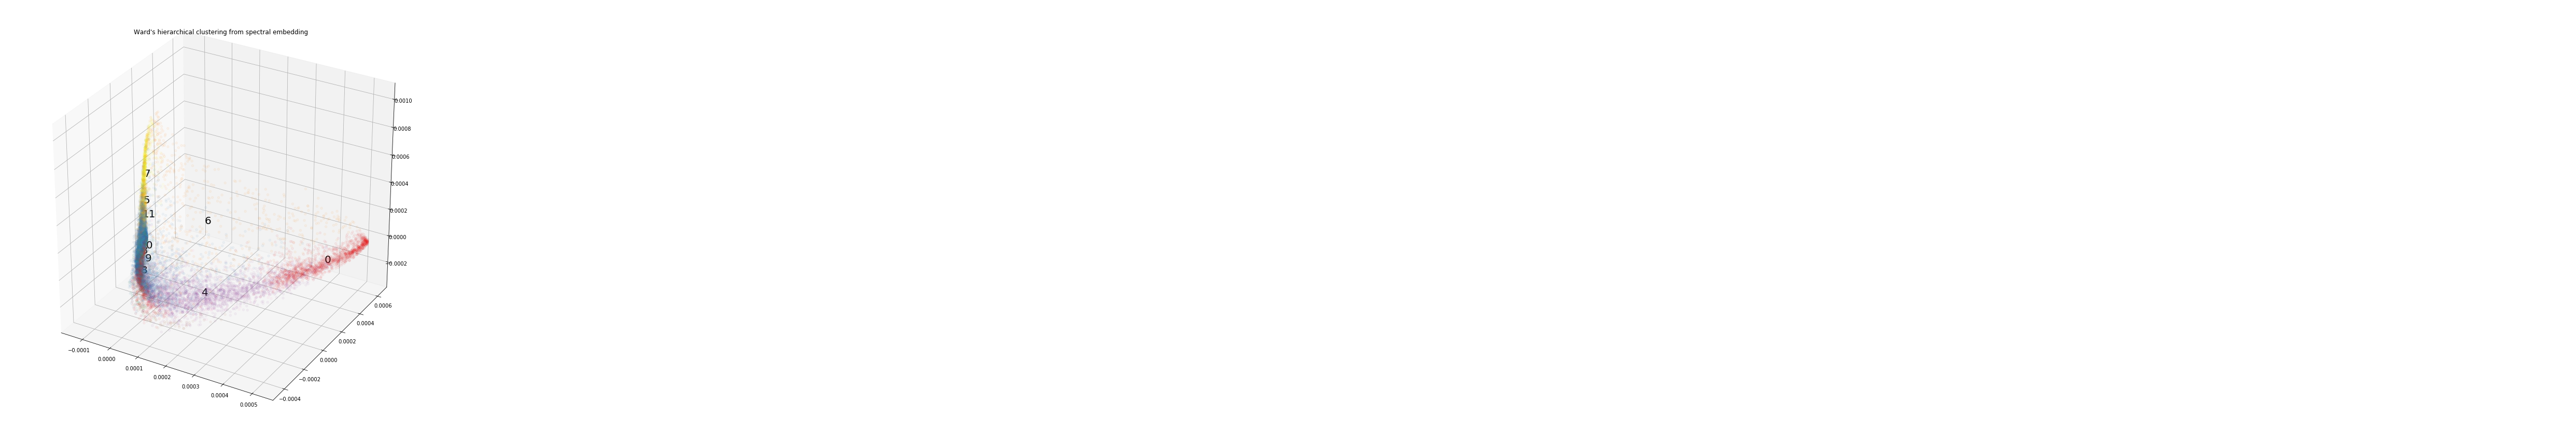

In [37]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=spect_emb_3[:,0],
           ys=spect_emb_3[:,1],
           zs=spect_emb_3[:,2],
           c=label, 
           alpha=0.05,
           cmap=plt.cm.Set1)

# ax.scatter(xs=centroides_median[:,0],
#            ys=centroides_median[:,1],
#            zs=centroides_median[:,2], 
#            s=500)

for i, txt in enumerate(list(set(author_data.cluster))):
    ax.text(centroides_median[i,0],
            centroides_median[i,1],
            centroides_median[i,2],
            '%s' % (str(txt)), size=20, zorder=1, color='k')

plt.title("Ward's hierarchical clustering from spectral embedding" )

# Wordclouds

In [38]:
# tfidf_data=pd.read_csv("tfidf_data_auth_416.csv",header=0,index_col="id")#("usr_txt_ftr_3.csv",header=0,index_col="id")
# del tfidf_data['Unnamed: 0']
tfidf_data.sample(20)
tfidf_data.shape

(18981, 500)

In [39]:
author_tfidf=tfidf_data#pd.read_csv("usr_txt_ftr_3.csv",header=0,index_col="id")
# del author_tfidf['don']
# del author_tfidf['just']
print(author_tfidf.shape)
author_tfidf.sample(20)

(18981, 500)


though  school  always  ever  better  myself  let  year  another  \
id                                                                          
2753990       0       1       0     0       1       2    0     0        0   
4086452       0       0       0     0       0       0    0     0        0   
21828         0       3       1     0       0       0    0     2        0   
3444234       4       1      11     5       4       3    5     3        4   
3951956       0       1       0     1       0       0    4     1        0   
3455583       3       0       0     0       1       0    0     0        0   
3774845       2       1       0     1       1       0    2     0        1   
1240631       2       1       2     1       3       0    1     0        5   
3242107       0       2       1     0       0       0    0     0        0   
4045507       0       1       2     3       2       0    2     1        3   
3148889       6       5       2     1       1       0    0     2        0   
3597182       1       0       0     0       0       3    2     0        0   
3563720       6       1       6     9       1      11    6     1        7   
3545692       0       0       1     1       0       0    0     2        0   
3997991       0       0       0     0       0       0    0     0        0   
3418546       0       0       0     1       1       0    0     1        1   
3920658       0       1       0     5       1       1   10     6        1   
3052887       0       1       3     0       1       1    0     1        1   
3465973       6       0      12    11       0       0    7     0        0   
1767662       1       8       1     0       4       1    1     2        2   

         many   ...    president  english  cute  longer  internet  dead  rock  \
id              ...                                                             
2753990     0   ...            0        0     0       0         0     0     0   
4086452     0   ...            0        0     0       0         0     0     0   
21828       3   ...            0        0     0       1         0     0     0   
3444234    14   ...            5        0     0       0         1     1     0   
3951956     0   ...            0        0     0       0         0     0     0   
3455583     0   ...            0        0     0       0         0     1     0   
3774845     0   ...            0        0     0       0         0     1     0   
1240631     1   ...            0        0     0       2         0     0     0   
3242107     0   ...            0        0     0       0         0     3     0   
4045507     4   ...            0        0     0       0         0     0     1   
3148889     0   ...            0        0     0       0         1     0     0   
3597182     0   ...            0        0     0       0         0     1     0   
3563720    16   ...            0        1     0       3         0     1     0   
3545692     1   ...            0        0     2       0         1     0     0   
3997991     0   ...            0        0     0       0         0     0     0   
3418546     0   ...            0        0     0       0         0     0     0   
3920658     4   ...           13        0     0       2         0     1     0   
3052887     0   ...            0        0     0       0         0     0     0   
3465973     2   ...            0        0     0       0         0     2     1   
1767662     1   ...            0        0     2       0         0     0     0   

         special  road  forget  
id                              
2753990        1     0       0  
4086452        0     0       0  
21828          0     0       1  
3444234        1     1       0  
3951956        0     0       0  
3455583        0     0       0  
3774845        1     0       0  
1240631        0     0       0  
3242107        0     0       0  
4045507        0     1       0  
3148889        1     0       0  
3597182        0     0       0  
3563720        2     0       3  
3545692        1     0       0  
399

In [40]:
# author_data=pd.read_csv("author_data_clusters_2.csv",header=0,index_col="id")
# print(author_data.shape)
# author_data.sample(20)

In [41]:
clrs_wrdcld=matplotlib.colors.LinearSegmentedColormap.from_list("", [#'#a50026',
                                                                     '#d73027',
                                                                     '#f46d43',
                                                                     '#fdae61',
#                                                                      '#fee090',
#                                                                      '#ffffbf',
#                                                                      '#e0f3f8',
#                                                                      '#abd9e9',
                                                                     '#74add1',
                                                                     '#4575b4',
                                                                     '#313695'])

In [42]:
pic_wide=900
def wrd_cld_dic_clust(clust_labels,clust_id,top_n=300):
    txt_freqs= author_tfidf[clust_labels==clust_id].sum(axis=0)
    indices = np.argsort(txt_freqs)[::-1]
    features =list(author_tfidf.columns)
    top_features = [[features[i],txt_freqs[i]] for i in indices[:top_n]]
    fr_dic={ str(features[i]).upper():txt_freqs[i] for i in indices[:top_n]}
    wc = WordCloud(width=pic_wide,  height=int(pic_wide*(9/21)), 
               background_color=None, mode="RGBA",min_font_size=8,
               colormap=clrs_wrdcld)#Dark2_r)#Paired_r)#tab10_r)#Set1_r) #
    wc.generate_from_frequencies(fr_dic)
    return wc

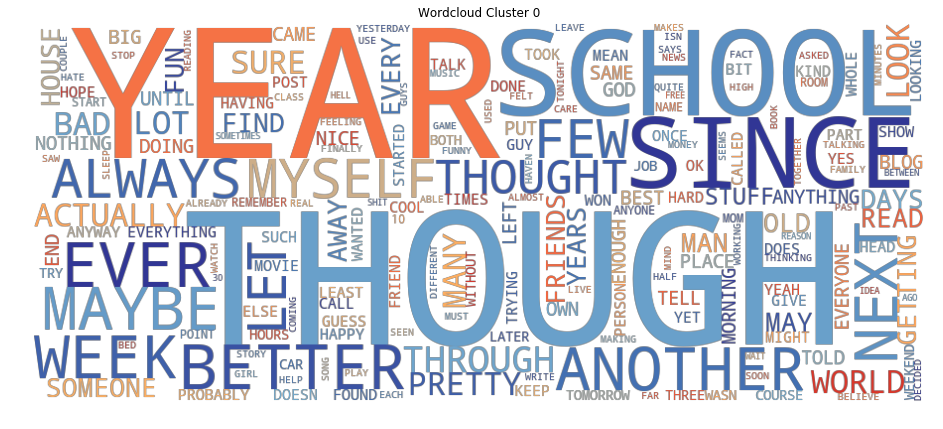

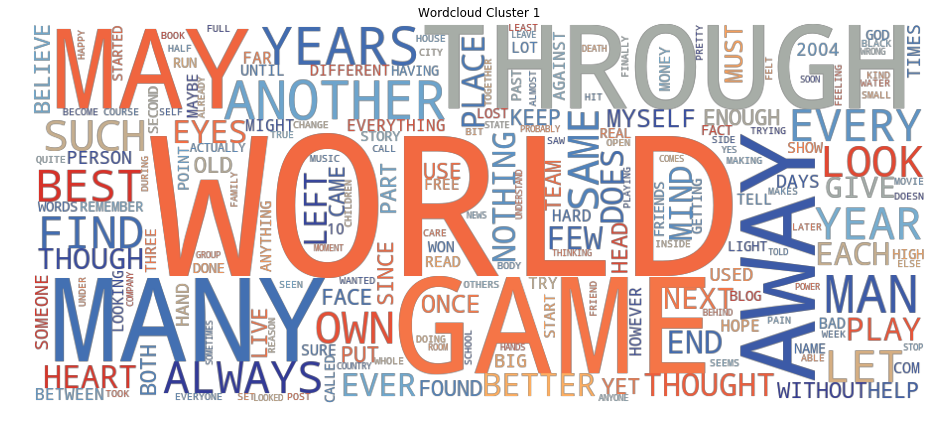

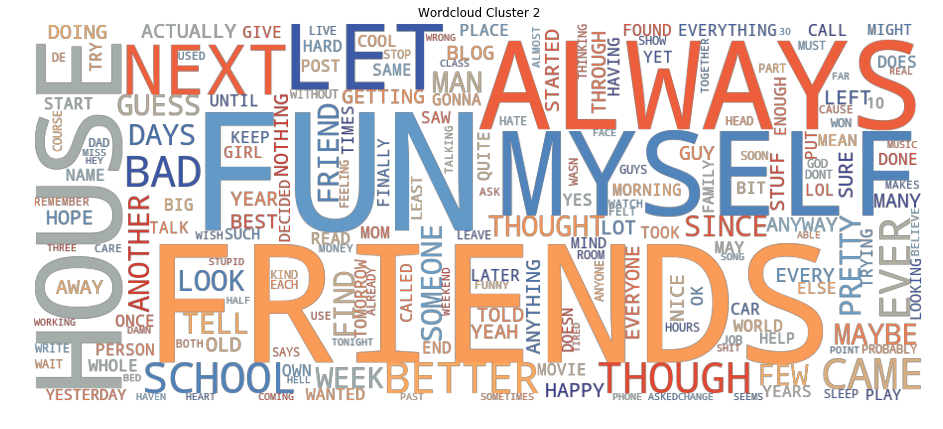

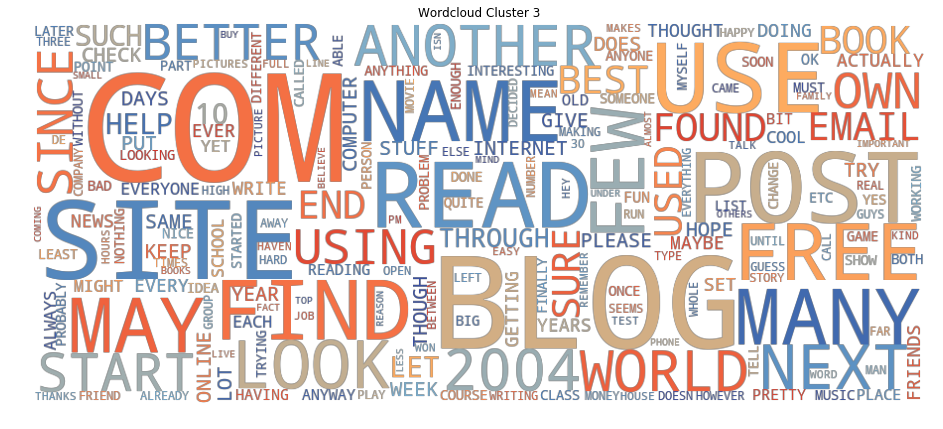

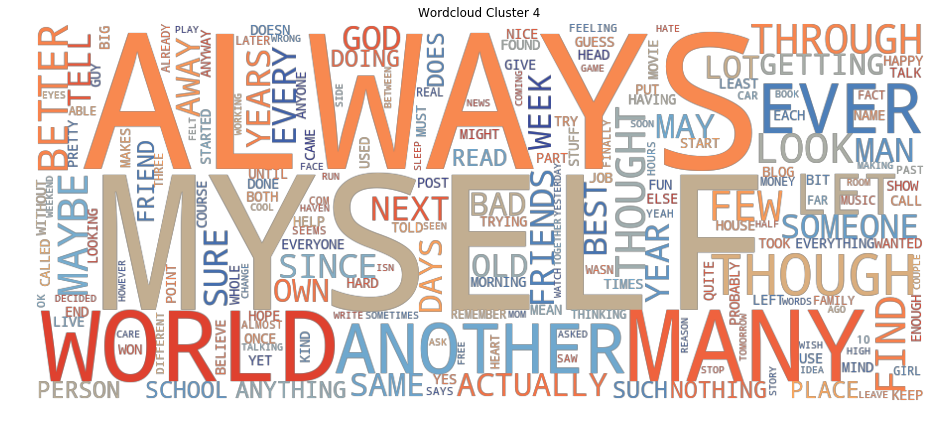

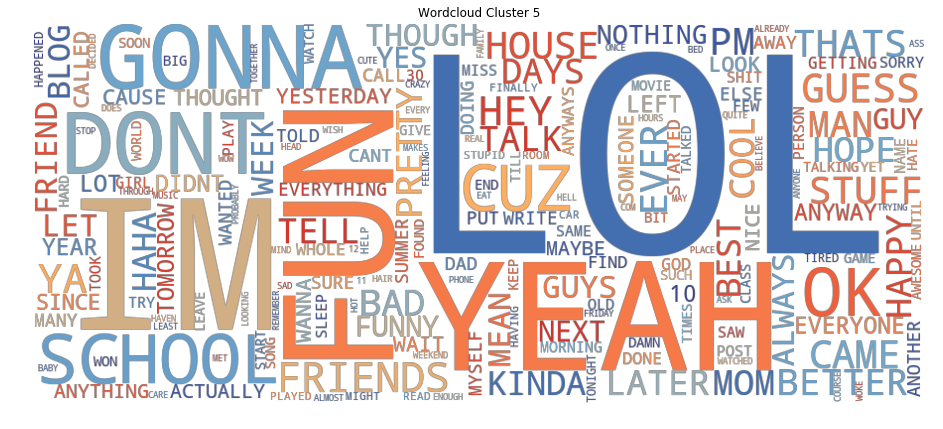

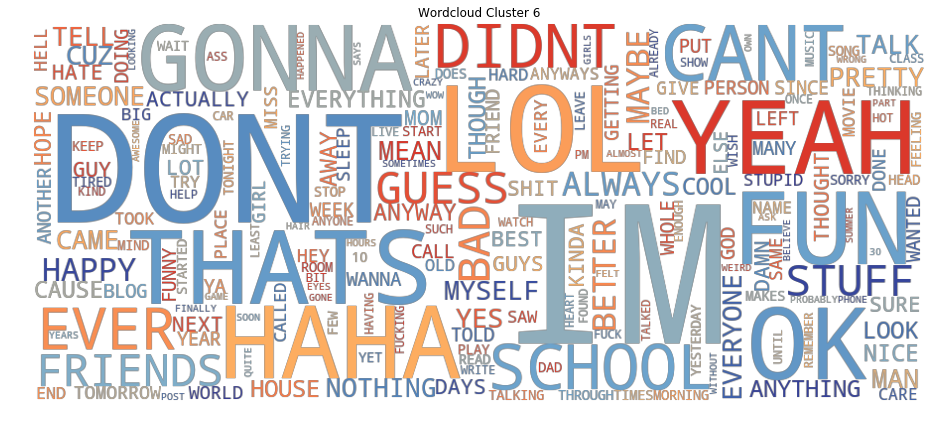

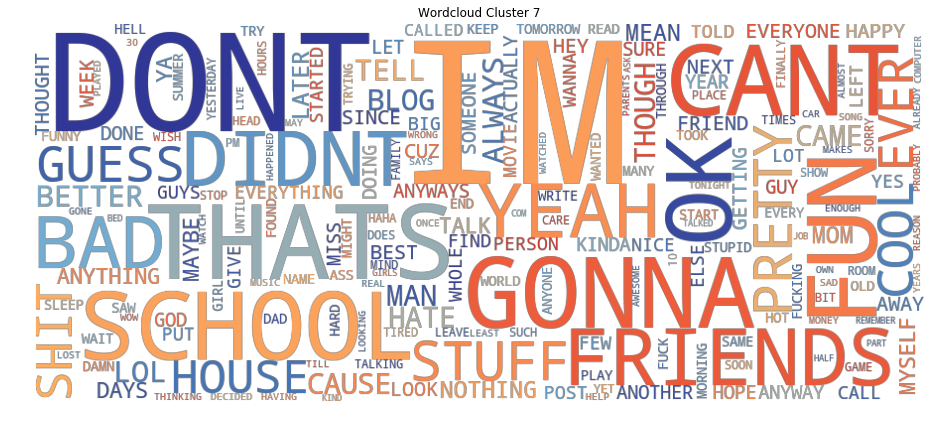

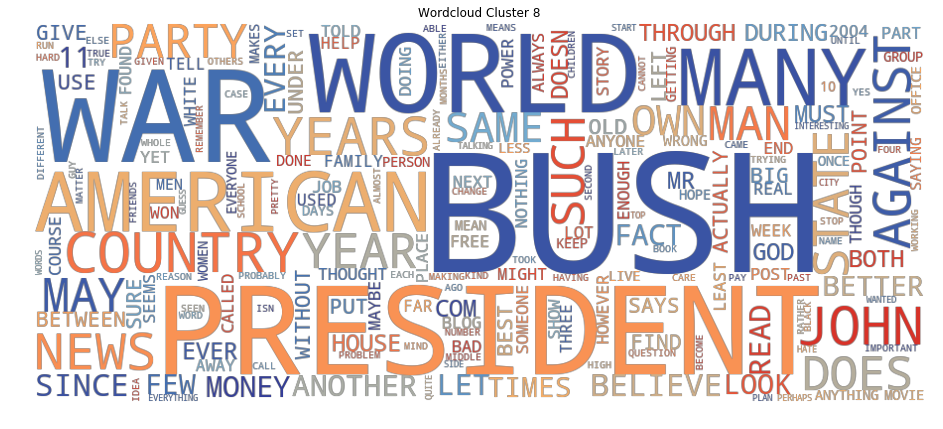

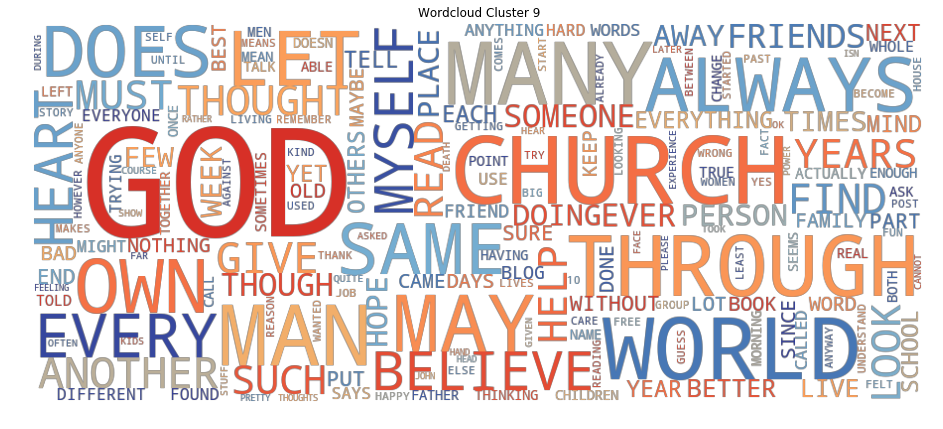

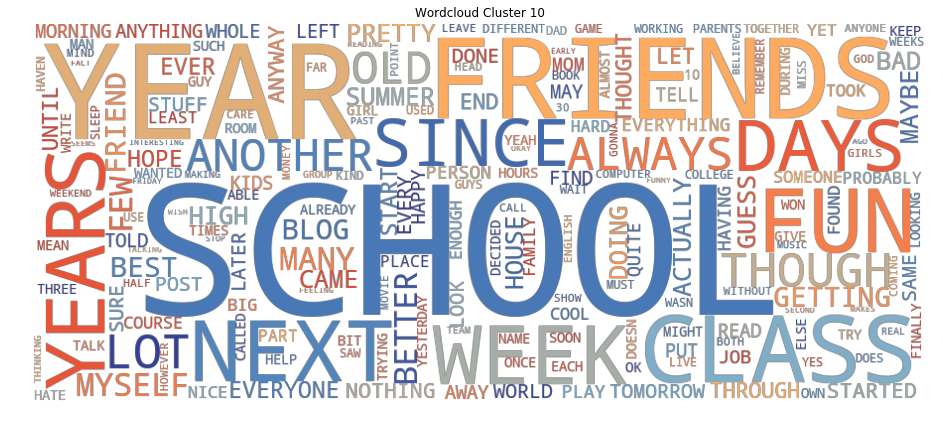

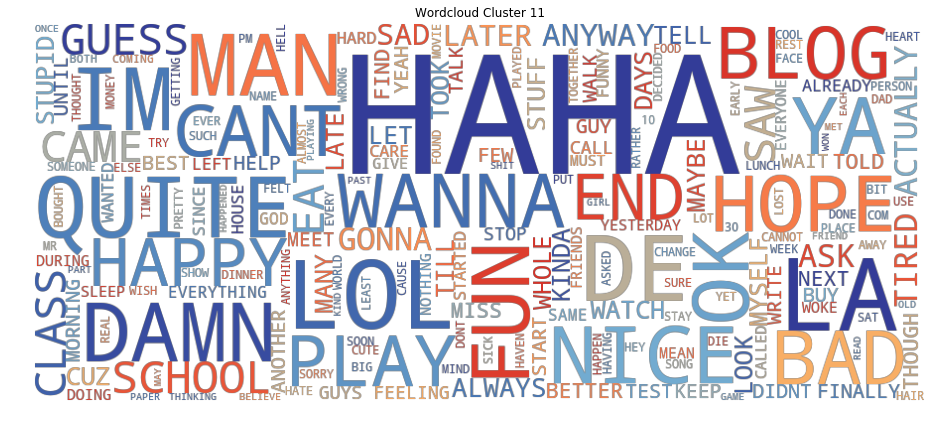

In [43]:
for i, txt in enumerate(list(set(author_data.cluster))):
    plt.figure(figsize=(16,9))
    plt.imshow(wrd_cld_dic_clust(author_data.cluster,i,200), interpolation='bilinear')
    plt.axis("off")
    plt.title("Wordcloud Cluster "+ str(i))


## Significative frequent word by cluster

In [44]:
freq_words_clust=((author_tfidf>0)*1).groupby(author_data.cluster).sum().T